# 2.1
# Далее мы рассмотрим способы соединения таблиц:

* связь между таблицами «один ко многим»;
* связь между таблицами «многие ко многим»;
* создание таблицы с внешними ключами;
* действия при удалении записи главной таблицы;
* заполнение таблицы с внешними ключами;
* добавление данных в таблицу с внешними ключами.

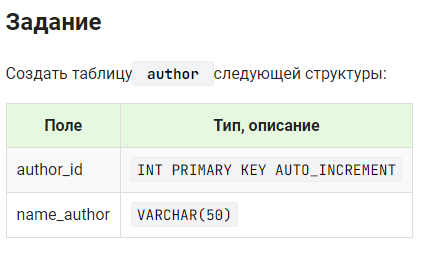

~~~~mySQL
CREATE TABLE author(
   author_id INT PRIMARY KEY AUTO_INCREMENT,
   name_author VARCHAR(50));
~~~~

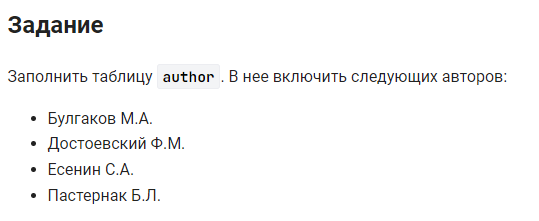

~~~~mySQL
INSERT INTO author(name_author)
VALUES 
      ('Булгаков М.А.'),
      ('Достоевский Ф.М.'),
      ('Есенин С.А.'),
      ('Пастернак Б.Л.');
~~~~

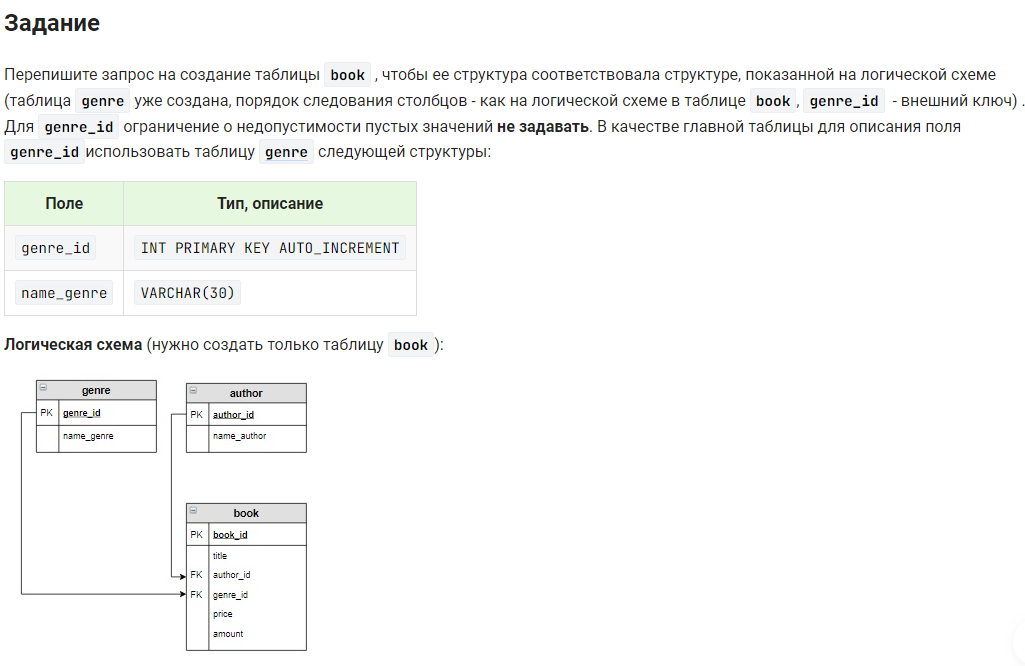

~~~~mySQL
CREATE TABLE book (
    book_id INT PRIMARY KEY AUTO_INCREMENT, 
    title VARCHAR(50), 
    author_id INT NOT NULL, 
    genre_id INT,
    price DECIMAL(8,2), 
    amount INT, 
    FOREIGN KEY (author_id) REFERENCES author (author_id),
    FOREIGN KEY (genre_id) REFERENCES genre (genre_id)
);
~~~~

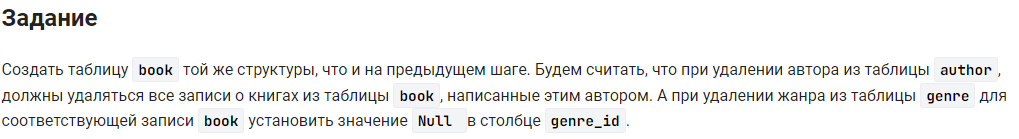

~~~~mySQL
CREATE TABLE book (
    book_id INT PRIMARY KEY AUTO_INCREMENT, 
    title VARCHAR(50), 
    author_id INT NOT NULL, 
    genre_id INT,
    price DECIMAL(8,2), 
    amount INT, 
    FOREIGN KEY (author_id) REFERENCES author (author_id) ON DELETE CASCADE,
    FOREIGN KEY (genre_id) REFERENCES genre (genre_id) ON DELETE SET NULL
);
~~~~

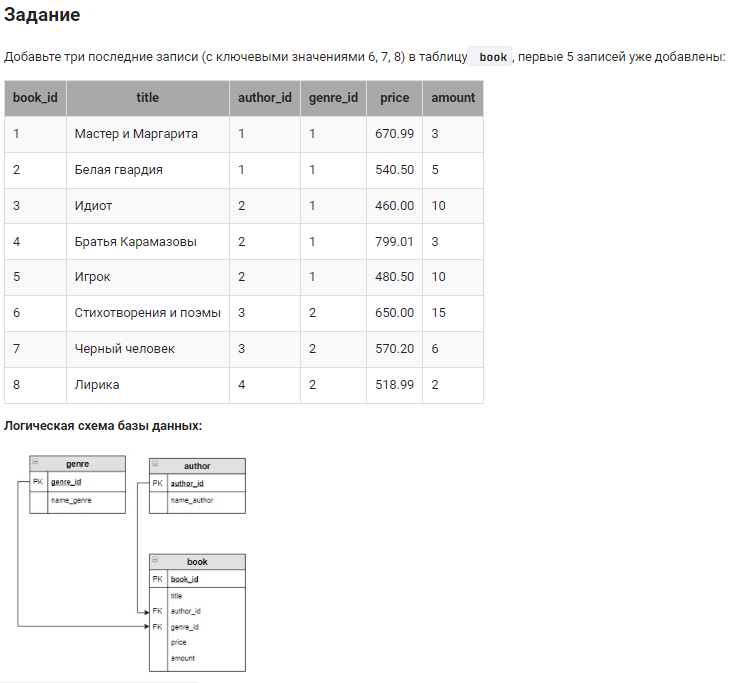

~~~~mySQL
INSERT INTO book (title, author_id, genre_id, price, amount)
VALUES
   ('Стихотворения и поэмы',	3,	2,	650.00,	15),
   ('Черный человек', 3, 2, 570.20, 6),
   ('Лирика', 4, 2, 518.99, 2);
~~~~

# 2.2
# Далее будут созданы запросы:

* для двух таблиц, внутреннее соединение INNER JOIN;
* для двух таблиц, внешние соединения LEFT JOIN и RIGHT JOIN;
* для двух таблиц, перекрестное соединение CROSS JOIN;
* выборки данных из нескольких таблиц;
* выборки данных из нескольких таблиц с группировкой;
* выборки данных с применением вложенных запросов;
* вложенные запросы в операторах соединения,
* операторы соединения, использование USING.
  
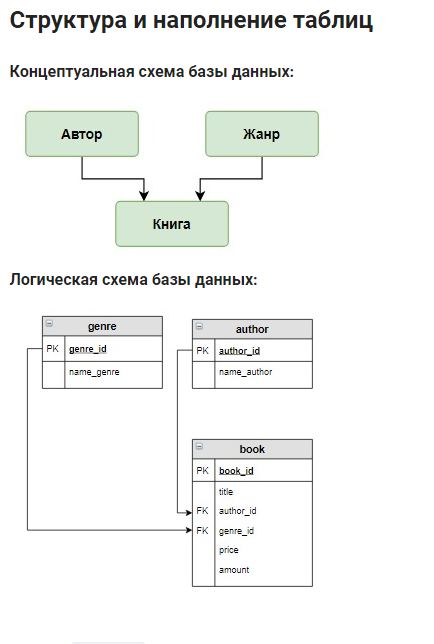

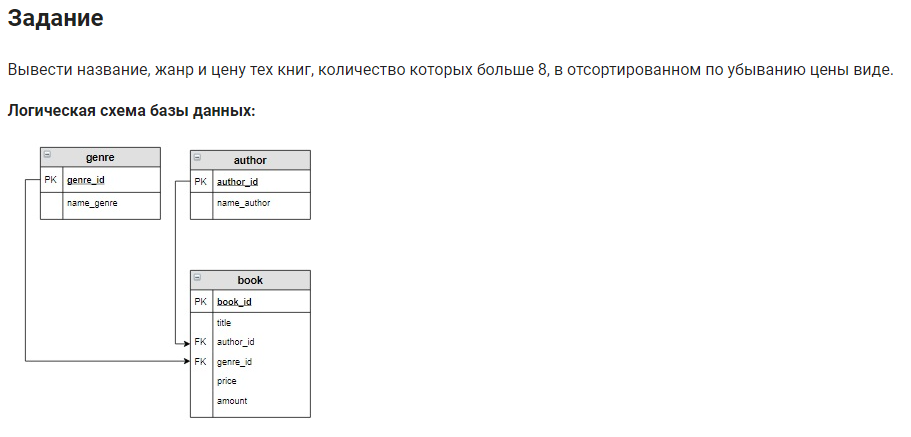

~~~~mySQL
SELECT b.title,
       gn.name_genre,
       b.price
  FROM 
       book AS b INNER JOIN genre AS gn
            ON b.genre_id = gn.genre_id
 WHERE amount > 8
 ORDER BY price DESC;
~~~~

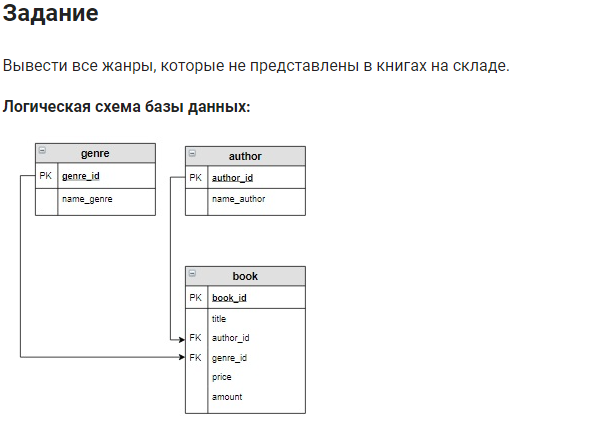

~~~~mySQL
SELECT name_genre
  FROM genre AS g LEFT JOIN book AS b
       ON g.genre_id = b.genre_id
 WHERE amount IS NULL;
~~~~

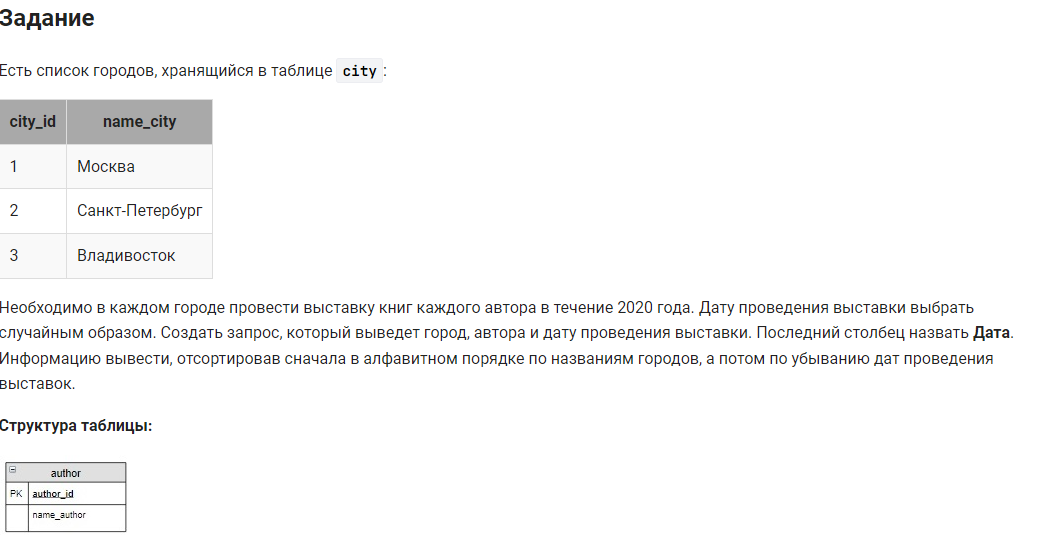

~~~~mySQL
SELECT name_city,
       name_author,
       DATE_ADD('2020-01-01', INTERVAL FLOOR(RAND() * 365) DAY) AS Дата
  FROM author CROSS JOIN city -- FROM author, city
 ORDER BY name_city, Дата DESC;
~~~~

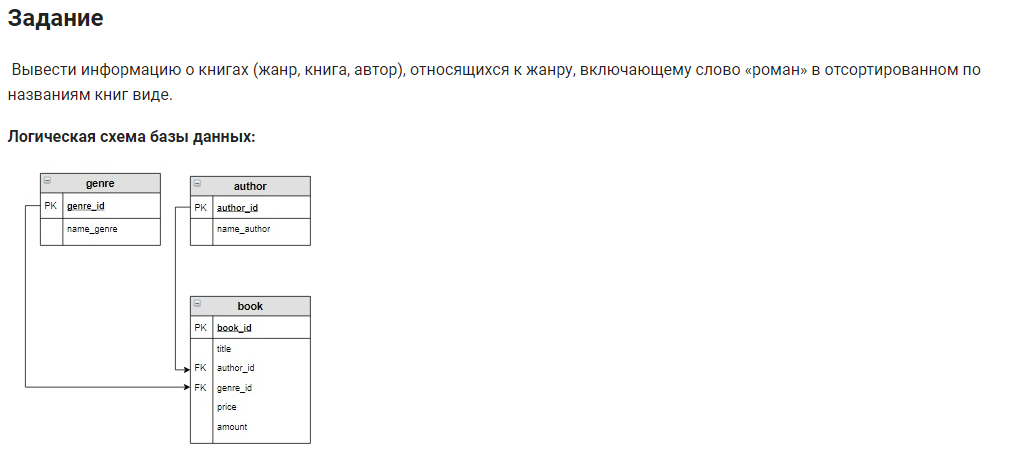

~~~~mySQL
SELECT name_genre,
       title,
       name_author
  FROM book
       INNER JOIN genre ON book.genre_id = genre.genre_id
       INNER JOIN author ON book.author_id = author.author_id
 WHERE name_genre LIKE '%роман%'
 ORDER BY title;
~~~~

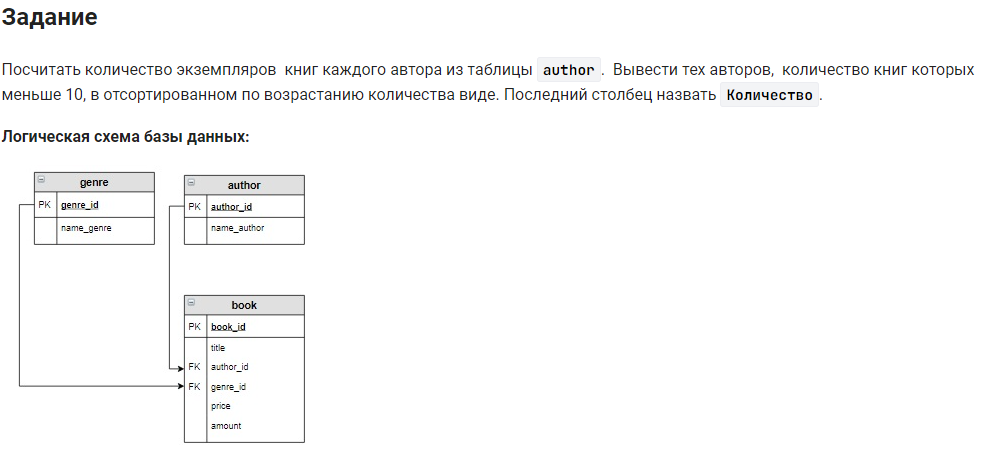

~~~~mySQL
SELECT name_author,
       SUM(amount) AS Количество
  FROM author 
       LEFT JOIN book
    ON author.author_id = book.author_id
 GROUP BY name_author
HAVING SUM(amount) < 10
    OR SUM(amount) IS NULL
 ORDER BY Количество;
~~~~

~~~~mySQL
SELECT name_author,
       SUM(amount) AS Количество
  FROM author 
       LEFT JOIN book
    ON author.author_id = book.author_id
 GROUP BY name_author
HAVING SUM(IF (amount IS NULL, 0, amount)) < 10
 ORDER BY Количество;
~~~~

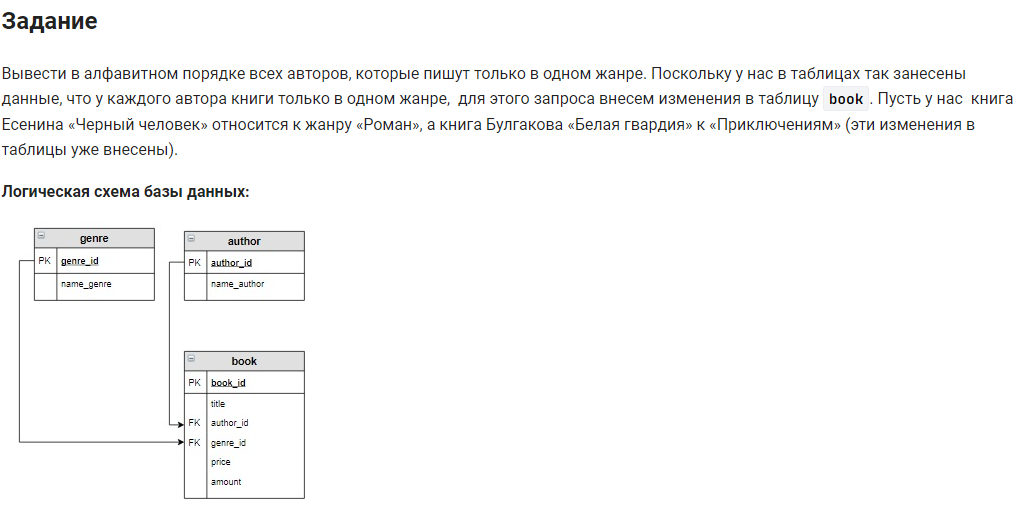

~~~~mySQL
SELECT name_author
  FROM book
       LEFT JOIN author ON book.author_id = author.author_id
 GROUP BY book.author_id
HAVING COUNT(DISTINCT(genre_id)) = 1
 ORDER BY name_author;
~~~~

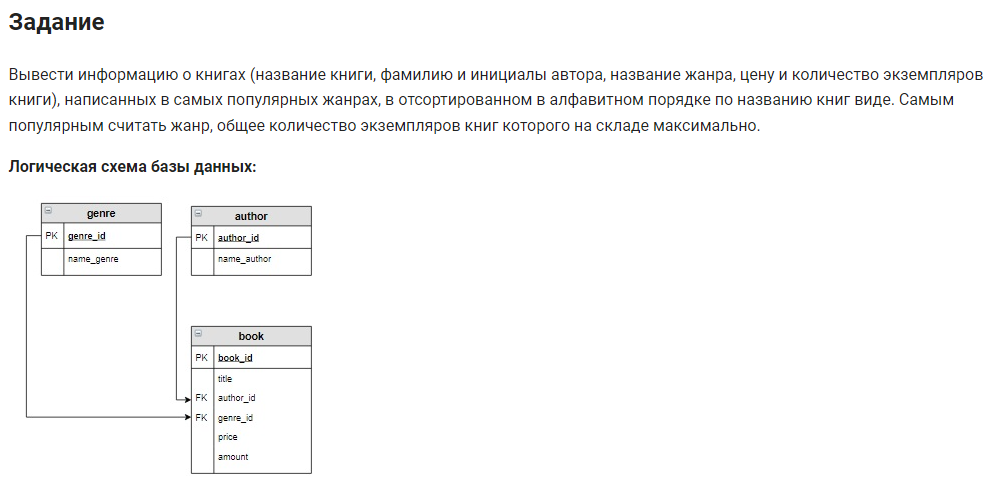

~~~~mySQL
SELECT title,
       name_author,
       name_genre,
       price,
       amount
  FROM book
       INNER JOIN genre
          ON book.genre_id = genre.genre_id
       INNER JOIN author
          ON book.author_id = author.author_id
 WHERE book.genre_id IN 
       (SELECT g.genre_id 
          FROM (SELECT genre_id,
                       SUM(amount) AS sum_amount
                  FROM book 
                 GROUP BY genre_id) g 
                   INNER JOIN (
                                SELECT SUM(amount) AS sum_amount
                                  FROM book 
                                 GROUP BY genre_id
                                 ORDER BY sum_amount DESC
                                 LIMIT 1) max_amount
                   ON g.sum_amount = max_amount.sum_amount)
 ORDER BY title;
~~~~

## Будет работать быстрее.
~~~~mySQL
SELECT title,
       name_author,
       name_genre,
       price,
       amount
  FROM (SELECT *
          FROM genre
         WHERE genre_id IN 
                       (SELECT g.genre_id 
                          FROM (SELECT genre_id,
                                       SUM(amount) AS sum_amount
                                  FROM book 
                                 GROUP BY genre_id) g 
                                   INNER JOIN (
                                                SELECT SUM(amount) AS sum_amount
                                                  FROM book 
                                                 GROUP BY genre_id
                                                 ORDER BY sum_amount DESC
                                                 LIMIT 1) max_amount
                                   ON g.sum_amount = max_amount.sum_amount)) AS g

       LEFT JOIN book
          ON  book.genre_id = g.genre_id
       INNER JOIN author
          ON book.author_id = author.author_id
 ORDER BY title;
~~~~

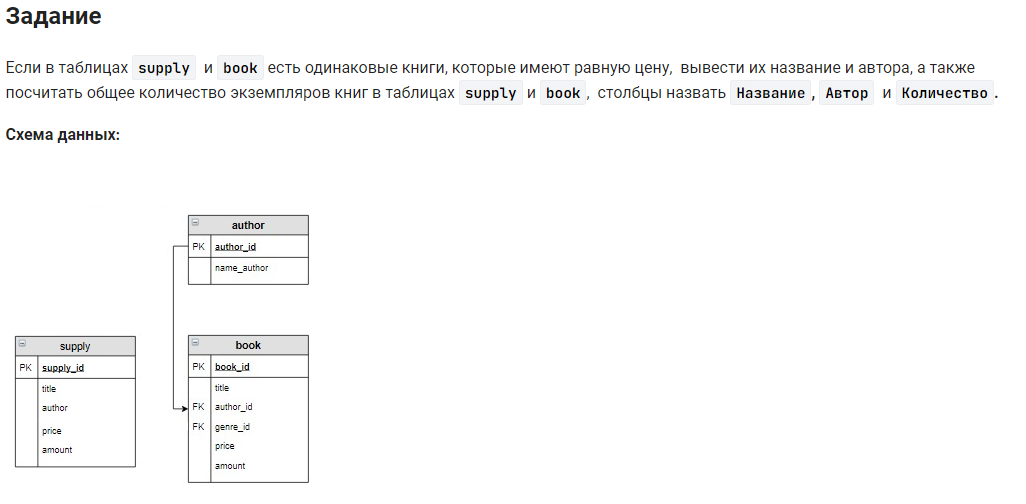

~~~~mySQL
SELECT b.title AS Название,
       a.name_author AS Автор,
       (s.amount + b.amount) AS Количество
  FROM (book AS b
       INNER JOIN author AS a USING (author_id))
       INNER JOIN supply AS s
               ON (b.title, a.name_author, b.price) = 
                  (s.title, s.author, s.price);
~~~~

~~~~mySQL
SELECT b.title AS Название,
       a.name_author AS Автор,
       (s.amount + b.amount) AS Количество
  FROM (book b
       INNER JOIN author a USING (author_id))
       INNER JOIN supply s ON
                  b.title = s.title
              AND a.name_author = s.author
              AND b.price = s.price;
~~~~

# 2.3
# Далее мы рассмотрим  запросы на корректирову данных:
  
* для книг, которые уже есть на складе по той же цене, что и в поставке,  - увеличить их количество на значение, указанное в поставке;  
* для книг, которые уже есть на складе, но цена книги в поставке отличается, - увеличить количество экземпляров и вычислить новую цену, при расчете учесть количество имеющихся и новых экземпляров книг;  
* для книг, которых на складе нет, - проверить, есть ли  автор книги в базе, если нет - занести фамилию автора, а потом добавить новую запись о книге, оставив поле для описания жанра пустым;  
* задать жанр для новых книг;  
* каскадное удаление записей связанных таблиц;
* удаление записей в главной таблице с сохранением записей в зависимой;
* удаление записей с использованием информации из связанных таблиц.

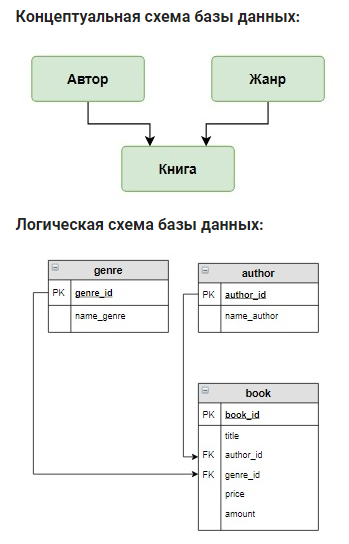

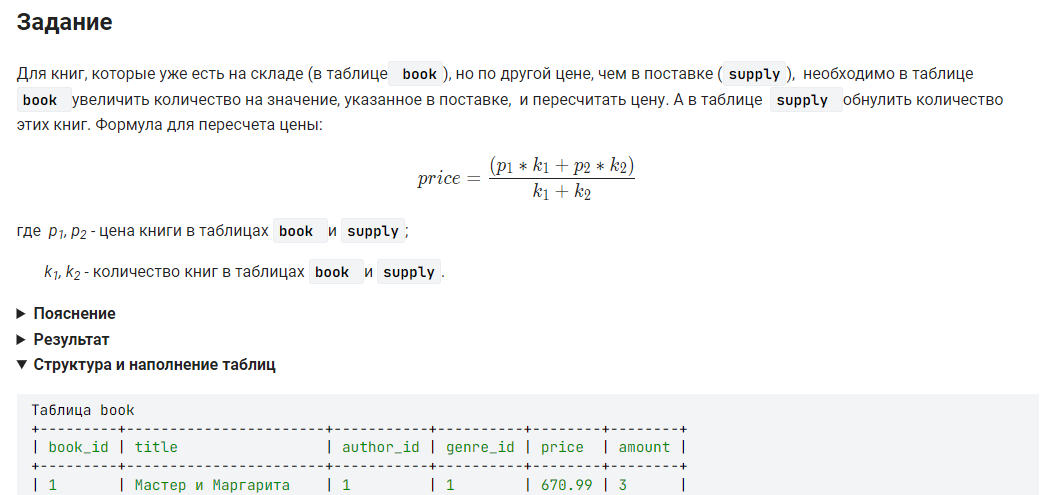

~~~~mySQL
UPDATE book AS b INNER JOIN author AS a ON b.author_id = a.author_id
                 INNER JOIN supply AS s ON (b.title, a.name_author) = (s.title, s.author)
   SET b.price = ((b.price * b.amount) + (s.price * s.amount)) / (b.amount + s.amount),
       b.amount = b.amount + s.amount,
       s.amount = 0
 WHERE b.price <> s.price;
~~~~

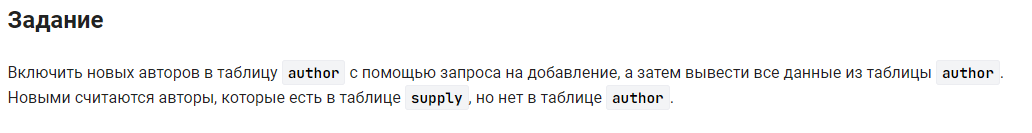

~~~~mySQL
INSERT INTO author (name_author) 
     SELECT s.author
       FROM author AS a
       RIGHT JOIN supply AS s ON s.author = a.name_author
      WHERE a.author_id IS NULL;
SELECT * FROM author;
~~~~

~~~~mySQL
INSERT INTO author (name_author) 
     SELECT s.author
       FROM supply AS s
       LEFT JOIN author AS a ON a.name_author = s.author
      WHERE a.author_id IS NULL;
SELECT * FROM author;
~~~~

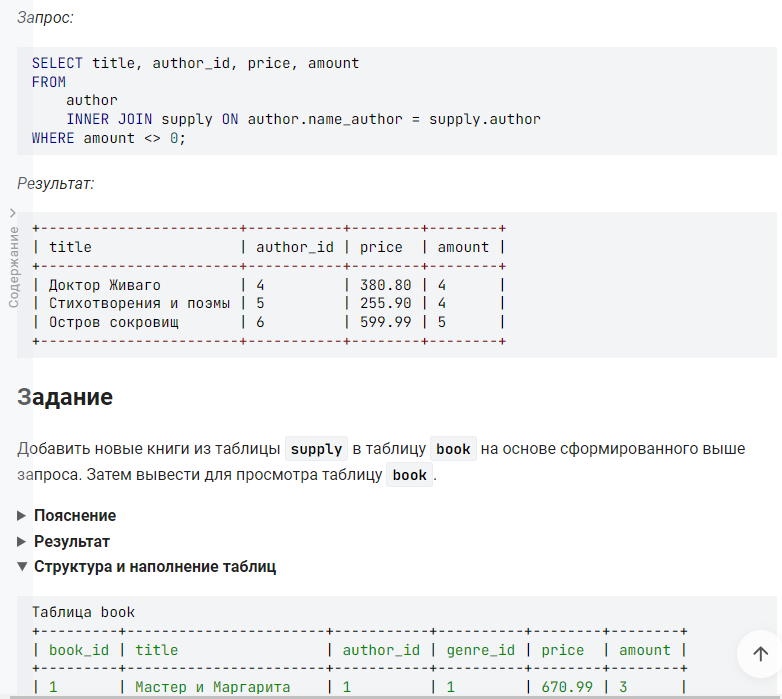

~~~~mySQL
INSERT INTO book (title, author_id, price, amount)
SELECT title, author_id, price, amount
FROM 
    author 
    INNER JOIN supply ON author.name_author = supply.author
WHERE amount <> 0;

SELECT * FROM book;
~~~~

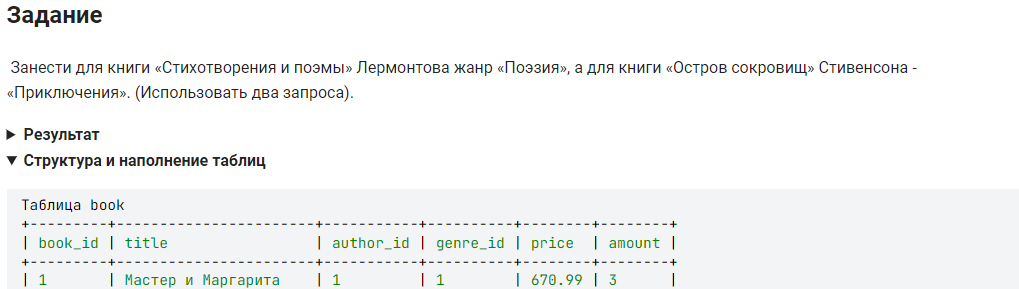

~~~~mySQL
UPDATE book LEFT JOIN author AS a ON a.author_id = book.author_id
   SET genre_id = (
       SELECT genre_id 
         FROM genre
        WHERE name_genre = 'Поэзия')
 WHERE title = 'Стихотворения и поэмы'
   AND a.name_author = 'Лермонтов М.Ю.';
   
UPDATE book LEFT JOIN author AS a ON a.author_id = book.author_id
   SET genre_id = (
       SELECT genre_id 
         FROM genre
        WHERE name_genre = 'Приключения')
 WHERE title = 'Остров сокровищ'
   AND a.name_author LIKE '%Стивенсон%';   
   
SELECT * FROM book;
~~~~

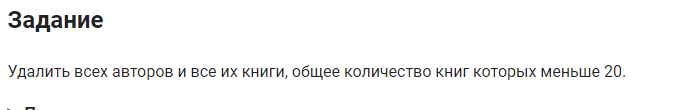
ON DELETE CASCADE

~~~~mySQL
DELETE FROM author
WHERE author_id IN 
     (SELECT author_id
        FROM book
       GROUP BY author_id
      HAVING SUM(amount) < 20
     );
~~~~

~~~~mySQL
DELETE FROM author
 USING author
 RIGHT JOIN (SELECT author_id
        FROM book
       GROUP BY author_id
      HAVING SUM(amount) < 20
     ) AS b
   ON b.author_id = author.author_id;
~~~~

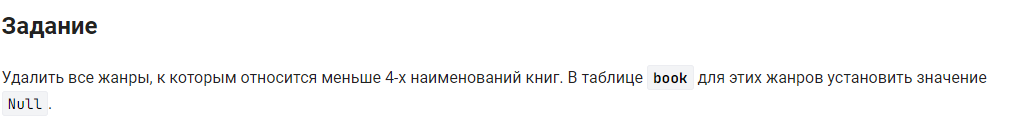
ON DELETE SET NULL

~~~~mySQL
DELETE FROM genre
 WHERE genre_id IN 
      (SELECT genre_id
         FROM book 
        GROUP BY genre_id
       HAVING COUNT(title) < 4);
~~~~

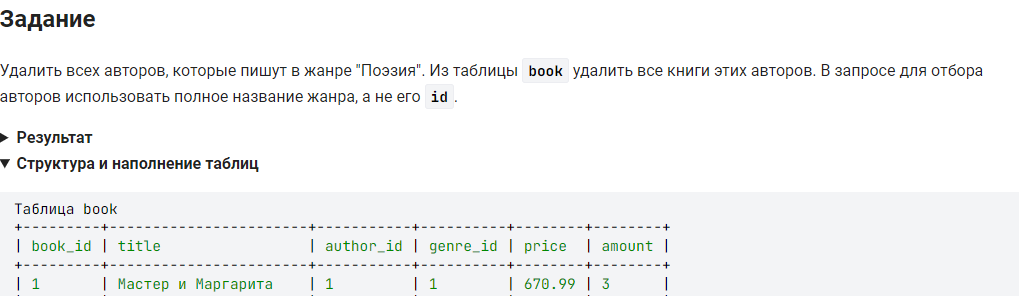

~~~~mySQL
DELETE FROM author
 USING author
       INNER JOIN book AS b ON b.author_id = author.author_id
       INNER JOIN genre AS g ON g.genre_id = b.genre_id
 WHERE g.name_genre = 'Поэзия';
~~~~

# 2.4 
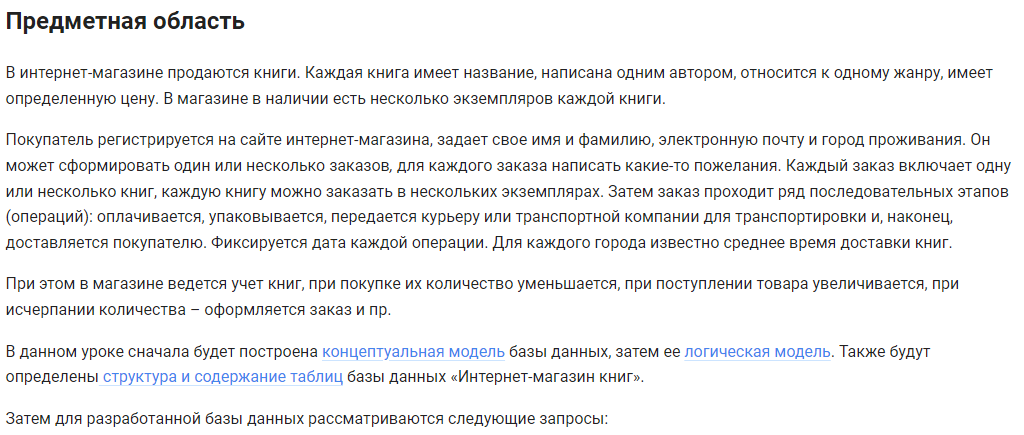

# Затем для разработанной базы данных рассматриваются следующие запросы:

* Вывести фамилии всех клиентов, которые заказали определенную книгу.
* Посчитать, сколько раз была заказана каждая книга.
* Вывести города, в которых живут клиенты магазина.
* Вывести информацию об оплате каждого заказа.
* Вывести подробную информацию о каждом заказе.
* Вывести информацию о движении каждого заказа.
* Вывести заказы, доставленные с опозданием.
* Вывести клиентов, которые заказывали книги определенного автора.
* Вывести самый популярный жанр.
* Сравнить ежемесячную выручку за текущий и прошлый год.


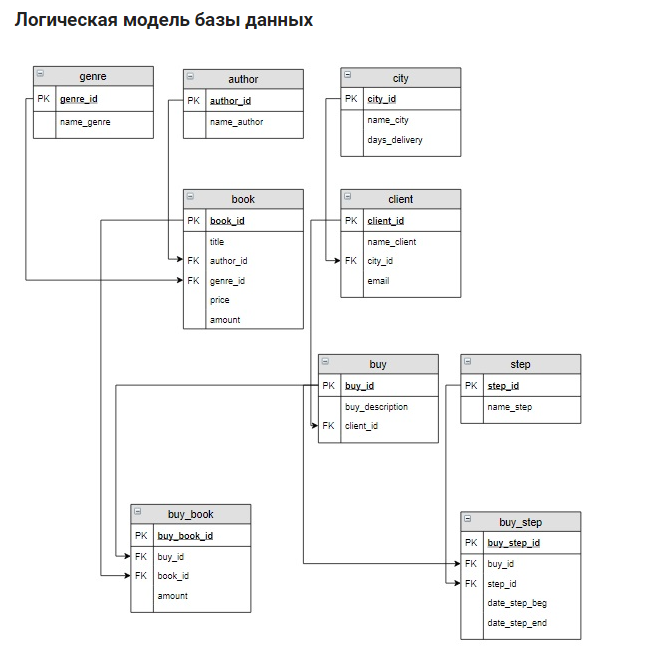

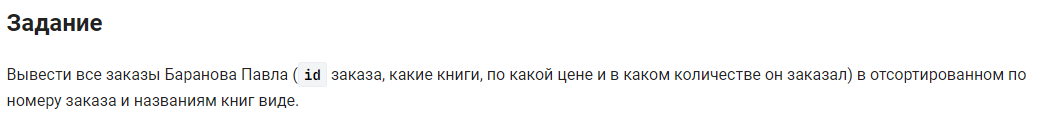

~~~~mySQL
SELECT bb.buy_id,
       b.title,
       b.price,
       bb.amount
  FROM client AS c
 INNER JOIN buy ON buy.client_id = c.client_id
 INNER JOIN buy_book AS bb ON bb.buy_id = buy.buy_id
 INNER JOIN book AS b ON b.book_id = bb.book_id
 WHERE c.name_client = 'Баранов Павел'
 ORDER BY bb.buy_id,
          b.title;
~~~~

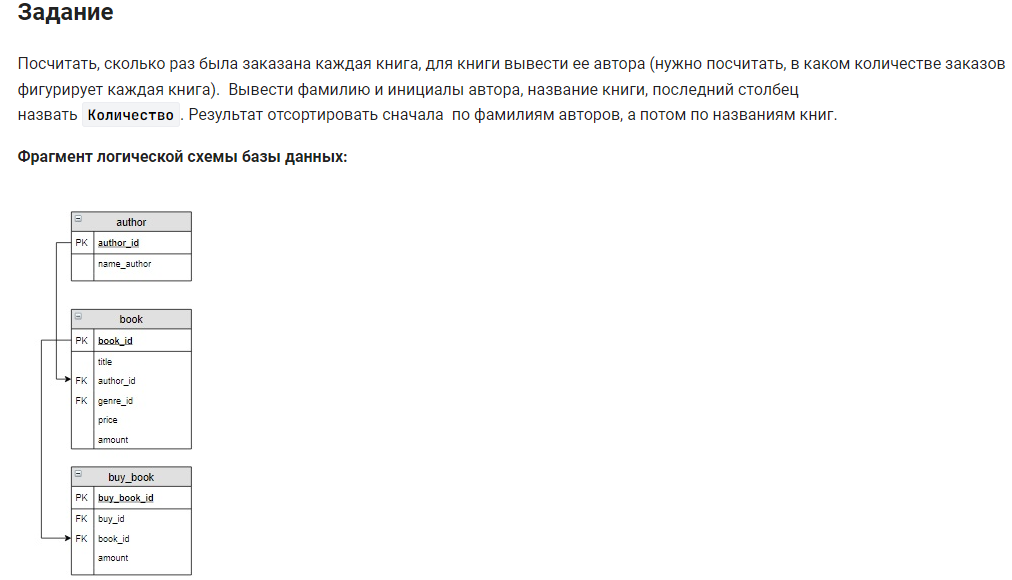

~~~~mySQL
SELECT a.name_author,
       b.title,
       COUNT(bb.buy_book_id) AS Количество
  FROM book AS b
  LEFT JOIN buy_book AS bb ON bb.book_id = b.book_id
  LEFT JOIN author AS a ON a.author_id = b.author_id
 GROUP BY b.title, a.name_author
 ORDER BY a.name_author, b.title;
~~~~

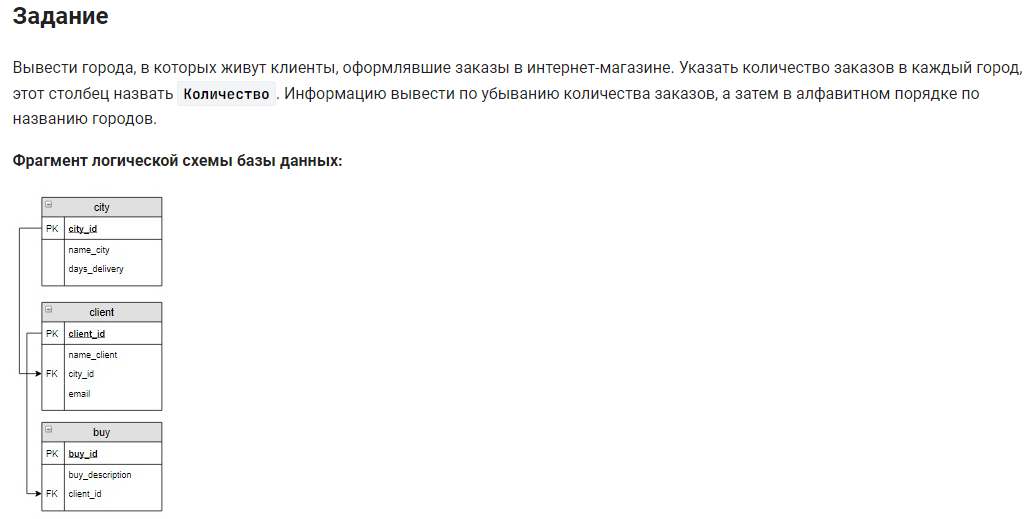

~~~~mySQL
SELECT city.name_city,
       COUNT(buy.buy_id) AS Количество
  FROM city 
 INNER JOIN client AS cl ON cl.city_id = city.city_id
 INNER JOIN buy ON cl.client_id = buy.client_id 
 GROUP BY city.name_city
 ORDER BY Количество DESC, city.name_city;
~~~~

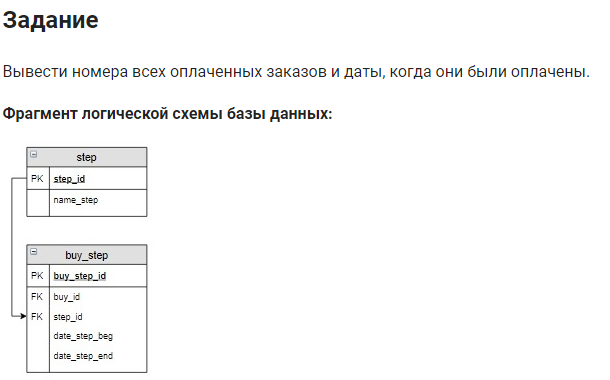

~~~~mySQL
SELECT bs.buy_id,
       bs.date_step_end
  FROM step 
  LEFT JOIN buy_step AS bs ON bs.step_id = step.step_id
 WHERE step.name_step = 'Оплата'
   AND bs.date_step_end IS NOT NULL;
~~~~

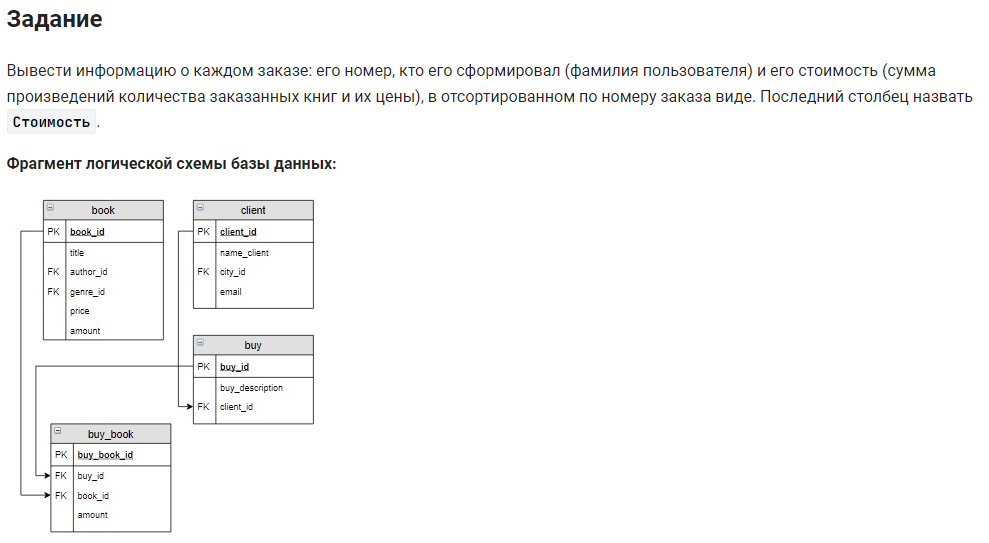

~~~~mySQL
SELECT buy.buy_id,
       c.name_client,
       SUM(bb.amount * b.price) AS Стоимость
  FROM buy 
  LEFT JOIN client AS c ON c.client_id = buy.client_id
  LEFT JOIN buy_book AS bb ON bb.buy_id = buy.buy_id
  LEFT JOIN book AS b ON b.book_id = bb.book_id
 GROUP BY buy.buy_id, c.name_client
 ORDER BY buy.buy_id;
~~~~

## С использованием USING, страдает читабельность и переносимость.
~~~~mySQL
SELECT buy.buy_id,
       c.name_client,
       SUM(bb.amount * b.price) AS Стоимость
  FROM buy 
  LEFT JOIN client AS c USING (client_id)
  LEFT JOIN buy_book AS bb USING (buy_id)
  LEFT JOIN book AS b USING (book_id)
 GROUP BY buy.buy_id, c.name_client
 ORDER BY buy.buy_id;
~~~~

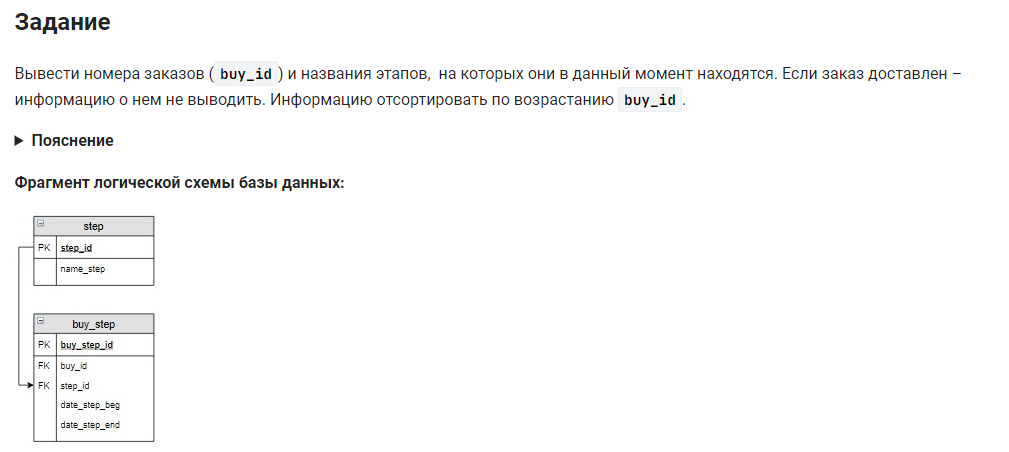

~~~~mySQL
SELECT last_step.buy_id,
       step.name_step
  FROM buy_step AS bs
 RIGHT JOIN 
           (SELECT buy_id,
                   MIN(date_step_beg) AS current_step
              FROM buy_step 
             WHERE date_step_end IS NULL
             GROUP BY buy_id
             ORDER BY buy_id) AS last_step
              ON (last_step.buy_id, last_step.current_step) = (bs.buy_id, bs.date_step_beg)
 LEFT JOIN step ON step.step_id = bs.step_id;
~~~~

## Решение лаконичное и без подзапросов.
~~~~mySQL
SELECT bs.buy_id,
       step.name_step
  FROM buy_step AS bs 
  LEFT JOIN step ON step.step_id = bs.step_id
 WHERE bs.date_step_beg AND bs.date_step_end IS NULL
 ORDER BY bs.buy_id;
~~~~

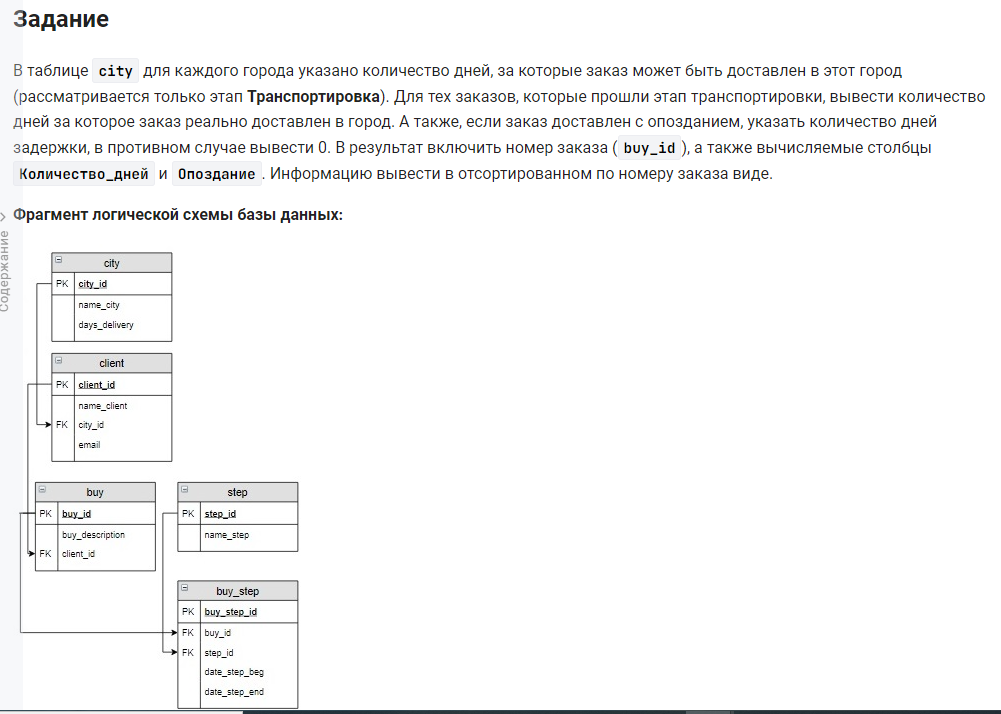

~~~~mySQL
SELECT bs.buy_id,
       DATEDIFF(bs.date_step_end,  bs.date_step_beg)  AS Количество_дней,
       IF(DATEDIFF(bs.date_step_end,  bs.date_step_beg) - city.days_delivery > 0, 
              DATEDIFF(bs.date_step_end,  bs.date_step_beg) - city.days_delivery, 0) AS Опоздание
  FROM buy_step AS bs
  LEFT JOIN step AS s ON s.step_id = bs.step_id
  LEFT JOIN buy ON buy.buy_id = bs.buy_id
  LEFT JOIN client ON client.client_id = buy.client_id
  LEFT JOIN city ON city.city_id = client.city_id
 WHERE bs.date_step_end IS NOT NULL
   AND s.name_step = 'Транспортировка';
~~~~

##  С использованием GREATEST  чуть читабельнее 
~~~~mySQL
SELECT bs.buy_id,
       DATEDIFF(bs.date_step_end,  bs.date_step_beg)  AS Количество_дней,
       GREATEST(DATEDIFF(bs.date_step_end,  bs.date_step_beg) - city.days_delivery, 0) AS Опоздание
  FROM buy_step AS bs
  LEFT JOIN step AS s ON s.step_id = bs.step_id
  LEFT JOIN buy ON buy.buy_id = bs.buy_id
  LEFT JOIN client ON client.client_id = buy.client_id
  LEFT JOIN city ON city.city_id = client.city_id
 WHERE bs.date_step_end IS NOT NULL
   AND s.name_step = 'Транспортировка';
~~~~

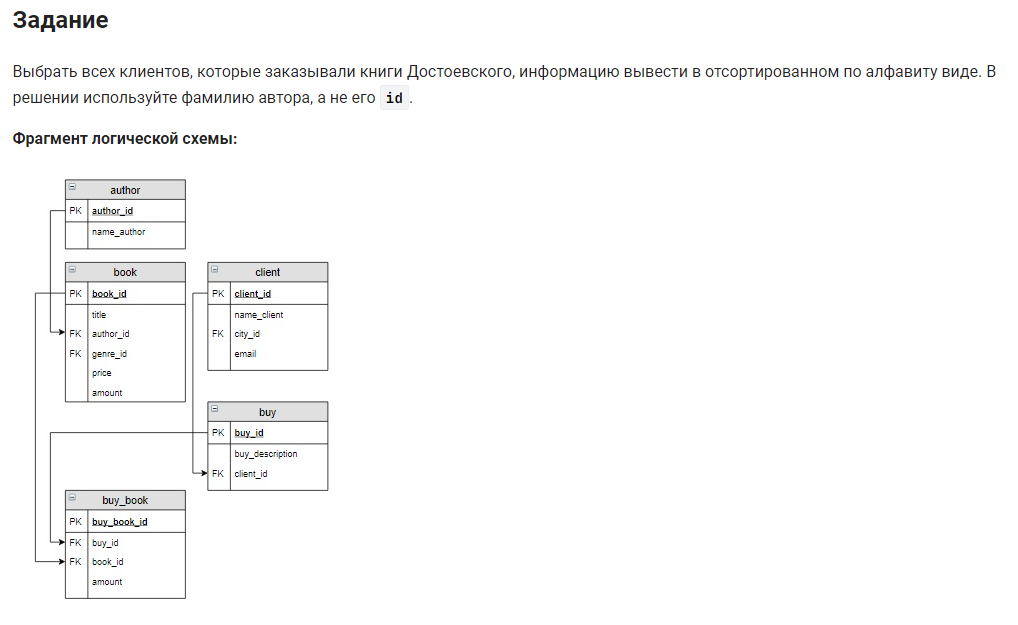

~~~~mySQL
SELECT DISTINCT(client.name_client)
  FROM author AS a
-- Важное дополнение, что можно сократить таблицу уже на этом шаге, а не после всех JOIN-ов. 
 INNER JOIN book ON book.author_id = a.author_id AND a.name_author = 'Достоевский Ф.М.'
 INNER JOIN buy_book AS bb ON bb.book_id = book.book_id
 INNER JOIN buy ON buy.buy_id = bb.buy_id 
 INNER JOIN client ON client.client_id = buy.client_id
-- WHERE a.name_author = 'Достоевский Ф.М.' --OR
-- a.name_author LIKE '%Достоевский%'
 ORDER BY name_client;
~~~~

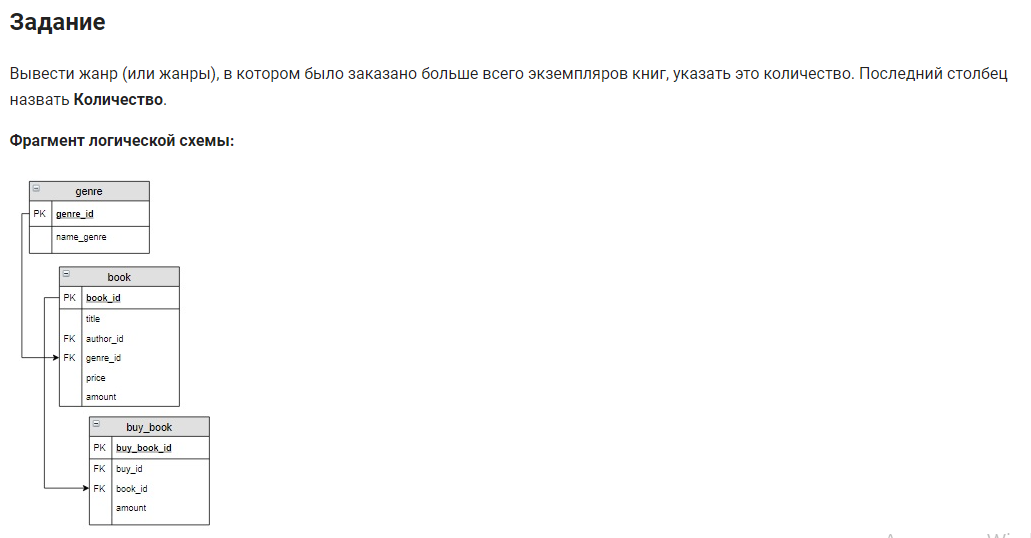

~~~~mySQL
SELECT genre.name_genre,
       SUM(bb.amount) AS Количество
  FROM book
 INNER JOIN buy_book AS bb ON bb.book_id = book.book_id
 INNER JOIN genre ON genre.genre_id = book.genre_id
 GROUP BY genre.name_genre
HAVING SUM(bb.amount) = (SELECT SUM(bb.amount) AS sum_amount
                           FROM book 
                          INNER JOIN buy_book AS bb ON bb.book_id = book.book_id
                          GROUP BY book.genre_id
                          ORDER BY sum_amount DESC
                          LIMIT 1);
~~~~

## С использованием временных таблиц.
~~~~mySQL
WITH genre_amount(name_genre, Количество) AS (
    SELECT genre.name_genre,
           SUM(bb.amount) AS Количество
      FROM book 
     INNER JOIN buy_book AS bb ON bb.book_id = book.book_id
     INNER JOIN genre ON genre.genre_id = book.genre_id
     GROUP BY genre.name_genre
     ORDER BY Количество DESC)
     
SELECT *
  FROM genre_amount
 WHERE Количество = (SELECT MAX(Количество)
                       FROM genre_amount);
~~~~

## С использованием временных таблиц и без использования подзапросов.
~~~~mySQL
WITH genre_amount(name_genre, Количество, rank_amount) AS (
    SELECT genre.name_genre,
           SUM(bb.amount) AS Количество,
           dense_rank() over (ORDER BY SUM(bb.amount) DESC) AS rank_amount
      FROM book 
     INNER JOIN buy_book AS bb ON bb.book_id = book.book_id
     INNER JOIN genre ON genre.genre_id = book.genre_id
     GROUP BY genre.name_genre)
     
SELECT name_genre,
       Количество
  FROM genre_amount
 WHERE rank_amount = 1;
~~~~

## Задание
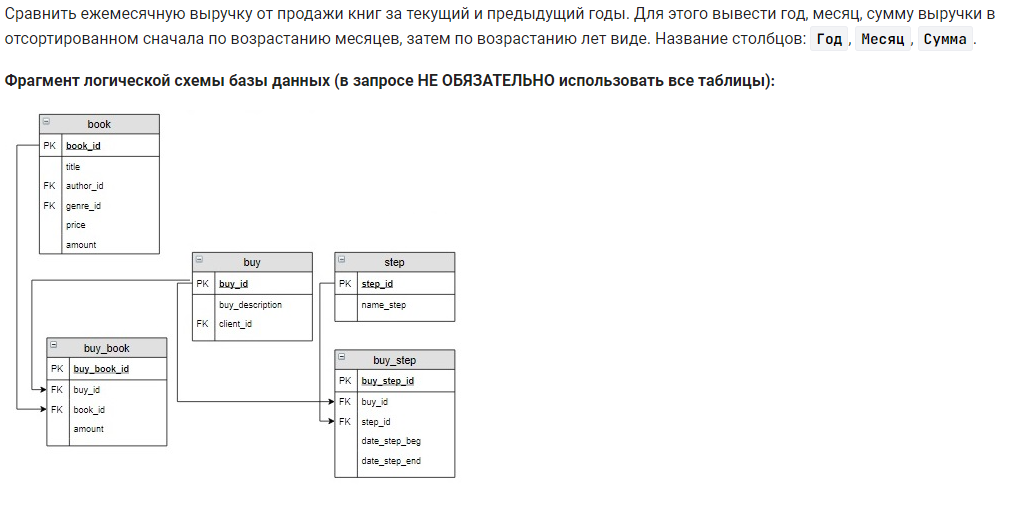

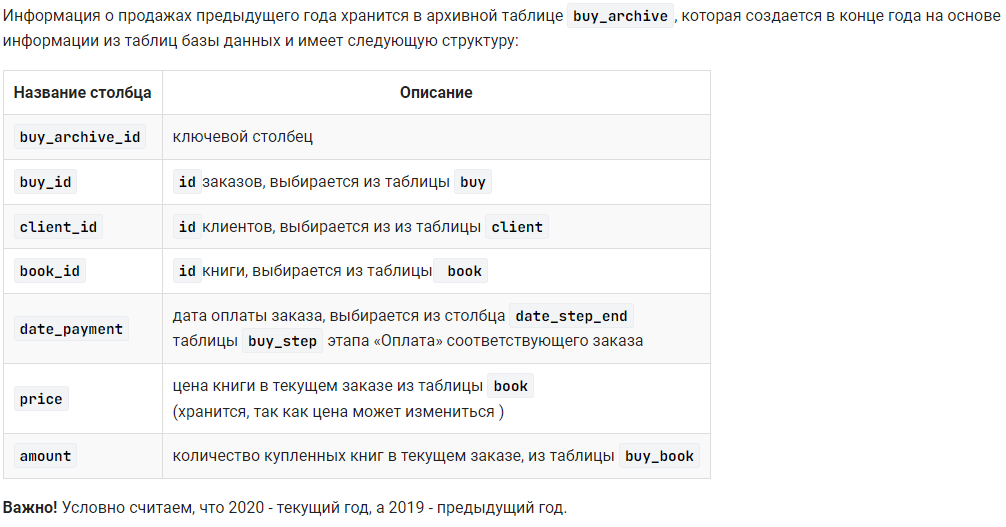

## В тексте задания не указанно, но: нужно вывести не номер месяца, а название;  отсортировать месяц нужно в алфавитном порядке, а не по номеру(порядку)
~~~~mySQL
SELECT YEAR(date_payment) AS Год, 
       MONTHNAME(date_payment) AS Месяц,
       SUM(price * amount) AS Сумма
  FROM buy_archive
 GROUP BY YEAR(date_payment), 
          MONTHNAME(date_payment)
UNION 
SELECT YEAR(bs.date_step_end) AS Год, 
       MONTHNAME(bs.date_step_end) AS Месяц,
       SUM(book.price * bb.amount) AS Сумма
  FROM step
 INNER JOIN buy_step AS bs ON bs.step_id = step.step_id 
                          AND step.name_step = 'Оплата' 
                          AND date_step_end IS NOT NULL
/* Можно обойтись без таблицы buy, связав сразу buy_step и buy_book*/
   /*INNER JOIN buy ON buy.buy_id = bs.buy_id   
     INNER JOIN buy_book AS bb ON bb.buy_id = buy.buy_id 
     INNER JOIN book ON book.book_id = bb.book_id*/
 
 INNER JOIN buy_book AS bb ON bb.buy_id = bs.buy_id 
 INNER JOIN book ON book.book_id = bb.book_id
 
 GROUP BY YEAR(bs.date_step_end), 
          MONTHNAME(bs.date_step_end)
 
 ORDER BY Месяц, Год;
~~~~

## Задание
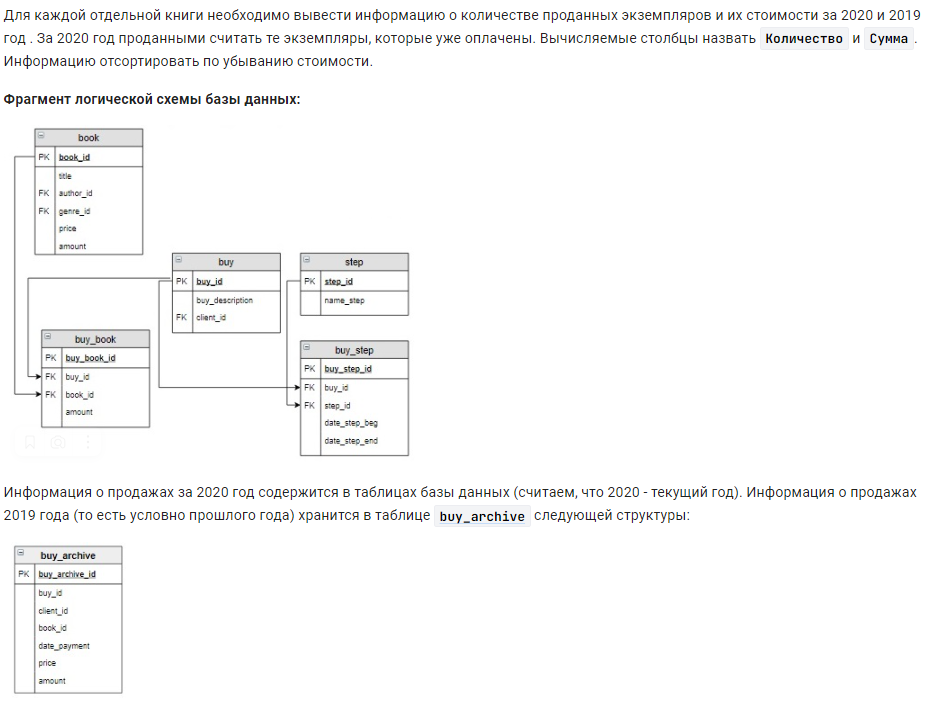

~~~~mySQL
WITH book_calculation (book_id, title, Количество, Сумма) AS (
SELECT bb.book_id,
       book.title,
       SUM(bb.amount) AS Количество,
       SUM(bb.amount * book.price) AS Сумма
  FROM step
 INNER JOIN buy_step AS bs ON bs.step_id = step.step_id
                          AND step.name_step = 'Оплата'
                          AND bs.date_step_end IS NOT NULL
 INNER JOIN buy_book AS bb ON bb.buy_id = bs.buy_id
 INNER JOIN book ON book.book_id = bb.book_id
 GROUP BY bb.book_id, book.title
 
UNION 
    
SELECT b_a.book_id,
       book.title,
       SUM(b_a.amount)  Количество,
       SUM(b_a.amount * b_a.price) Сумма

  FROM buy_archive AS b_a
 INNER JOIN book ON book.book_id = b_a.book_id
 GROUP BY b_a.book_id, book.title
)


SELECT title, 
       SUM(Количество) AS Количество,
       SUM(Сумма) AS Сумма
  FROM book_calculation
 GROUP BY book_id, title
 ORDER BY Сумма DESC;
~~~~

# Далее с помощью запросов корректировки данных будут выполнены следующие действия по обработке заказов в интернет-магазине:

* включение нового клиента в базу данных;
* формирование нового заказа некоторым пользователем;
* включение в заказ одной или нескольких книг с указанием их количества;
* уменьшение количества книг на складе;
* создание счета на оплату (полный счет, итоговый счет);
* добавление этапов продвижения заказа;
* фиксация дат прохождения каждого этапа заказа (начало этапа, завершение этапа).

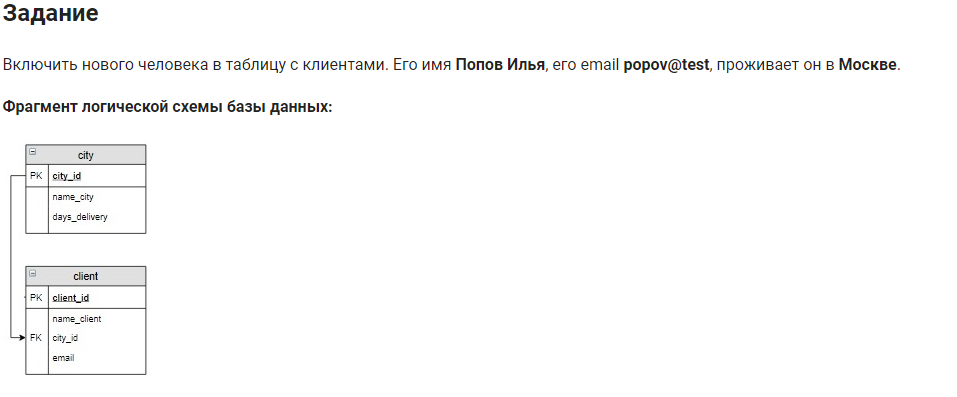

~~~~mySQL
INSERT INTO client (name_client, city_id, email)
SELECT 'Попов Илья', city_id, 'popov@test'
          FROM city
         WHERE name_city = 'Москва';
~~~~

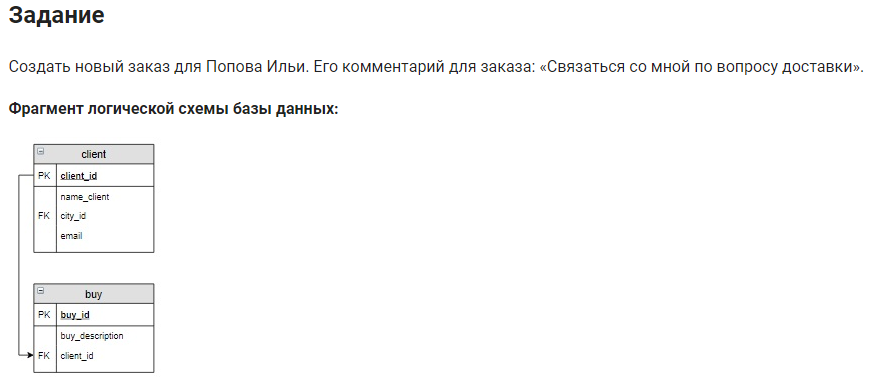

~~~~mySQL
INSERT INTO buy (buy_description, client_id)
SELECT 'Связаться со мной по вопросу доставки',
       client_id
  FROM client
 WHERE name_client = 'Попов Илья';
~~~~

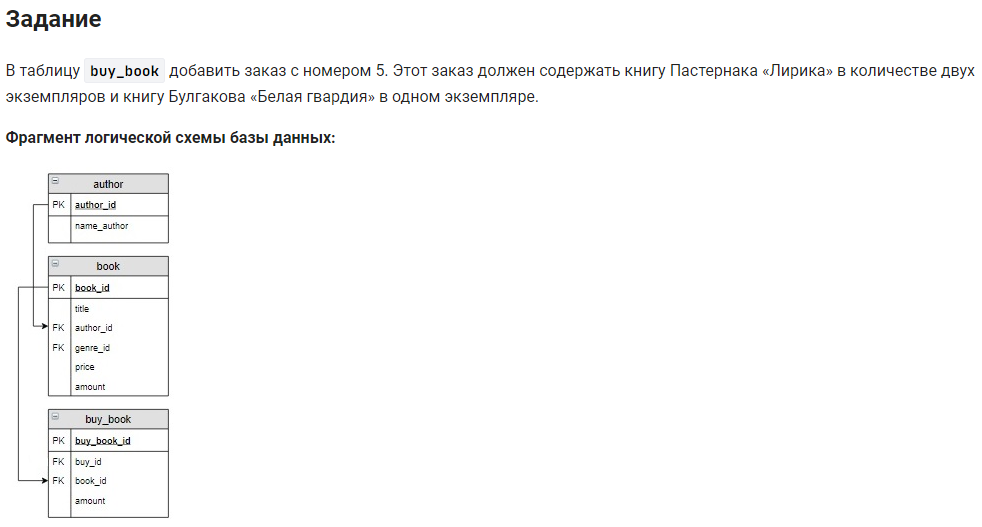

~~~~mySQL
INSERT INTO buy_book (buy_id, book_id, amount)
SELECT 5,
        book.book_id,
        2
   FROM book
  INNER JOIN author ON author.author_id = book.author_id 
                   AND author.name_author LIKE '%Пастернак%'
                   AND book.title = 'Лирика';
INSERT INTO buy_book (buy_id, book_id, amount)
SELECT 5,
        book.book_id,
        1
   FROM book
  INNER JOIN author ON author.author_id = book.author_id 
                   AND author.name_author LIKE '%Булгаков%'
                   AND book.title = 'Белая гвардия';                   
~~~~

## Вариант с использованием UNION ALL      
~~~~mySQL
INSERT INTO buy_book (buy_id, book_id, amount)
SELECT 5,
        book.book_id,
        2
   FROM book
  INNER JOIN author ON author.author_id = book.author_id 
                   AND author.name_author LIKE '%Пастернак%'
                   AND book.title = 'Лирика'
                   
UNION ALL                  

SELECT 5,
        book.book_id,
        1
   FROM book
  INNER JOIN author ON author.author_id = book.author_id 
                   AND author.name_author LIKE '%Булгаков%'
                   AND book.title = 'Белая гвардия';                   
~~~~

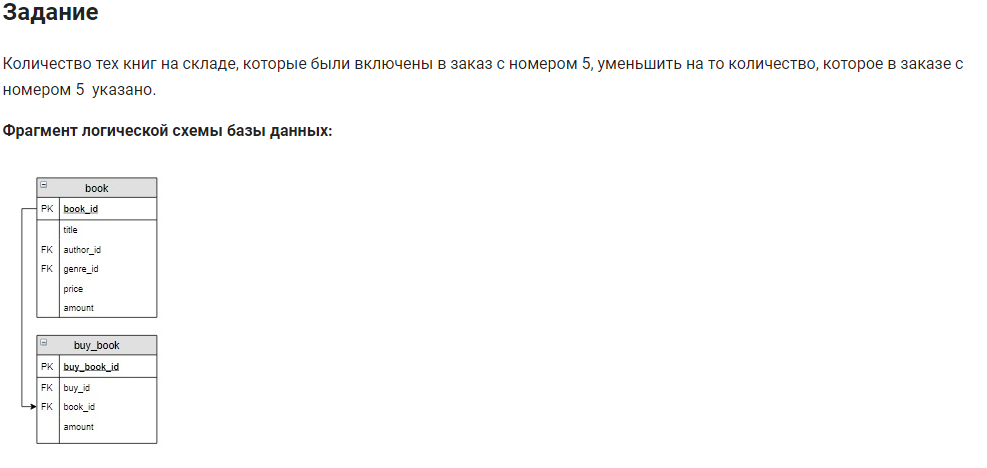

~~~~mySQL
UPDATE book
 INNER JOIN buy_book AS bb ON bb.book_id = book.book_id
                          AND bb.buy_id = 5
   SET book.amount = book.amount - bb.amount;
~~~~

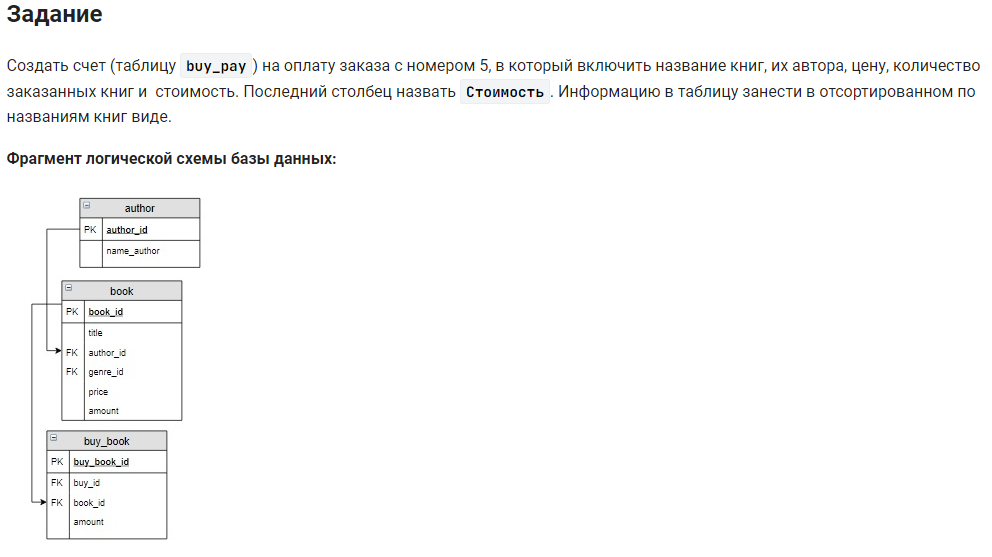

~~~~mySQL
CREATE TABLE buy_pay
SELECT book.title,
       author.name_author,
       book.price,
       bb.amount,
       book.price * bb.amount AS Стоимость
  FROM buy_book AS bb
 INNER JOIN book ON book.book_id = bb.book_id 
                AND bb.buy_id = 5
 INNER JOIN author ON author.author_id = book.author_id
 ORDER BY book.title;
~~~~

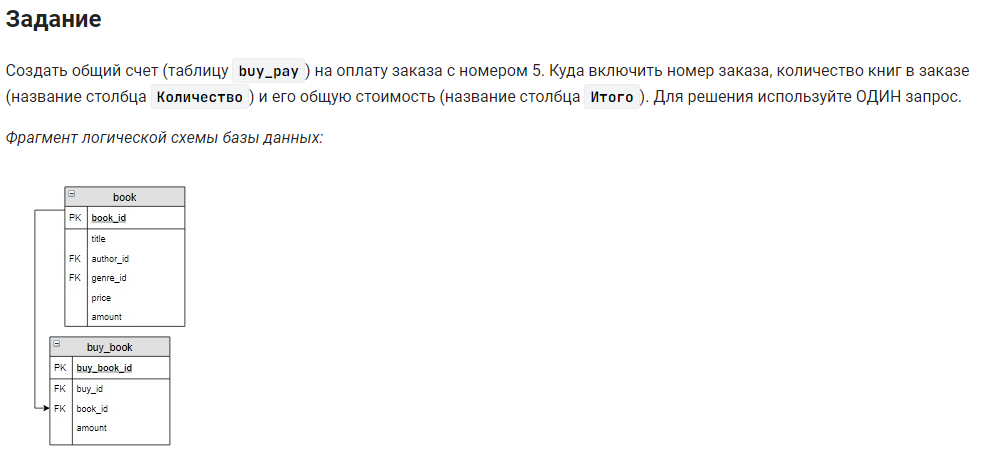

~~~~mySQL
CREATE TABLE buy_pay
SELECT buy_book.buy_id,
       SUM(buy_book.amount) AS Количество,
       SUM(buy_book.amount * book.price) AS Итого
  FROM buy_book
 INNER JOIN book ON book.book_id = buy_book.book_id
                AND buy_book.buy_id = 5;
~~~~

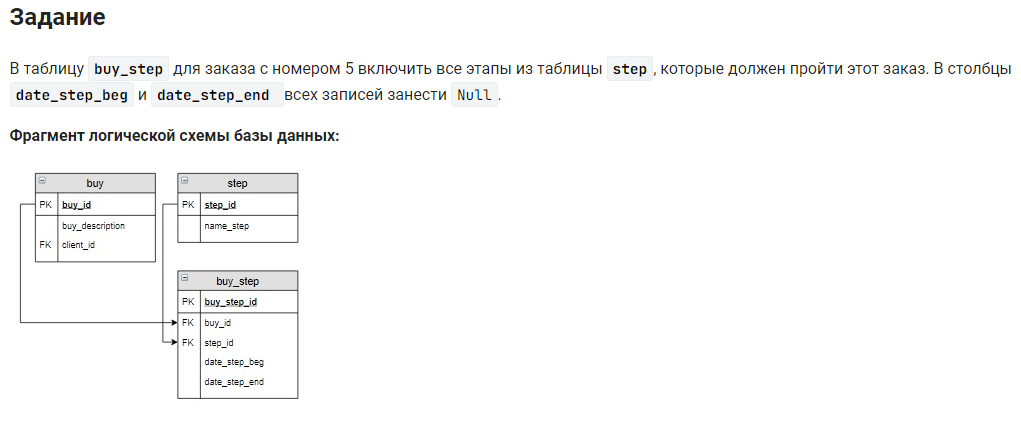

~~~~mySQL
INSERT INTO buy_step (buy_id, 
                      step_id,
                      date_step_beg,
                      date_step_end)
SELECT 5,
       step_id,
       NULL,
       NULL
FROM step;

-------- 

INSERT INTO buy_step (buy_id, 
                      step_id)
SELECT 5,
       step_id
FROM step;
~~~~

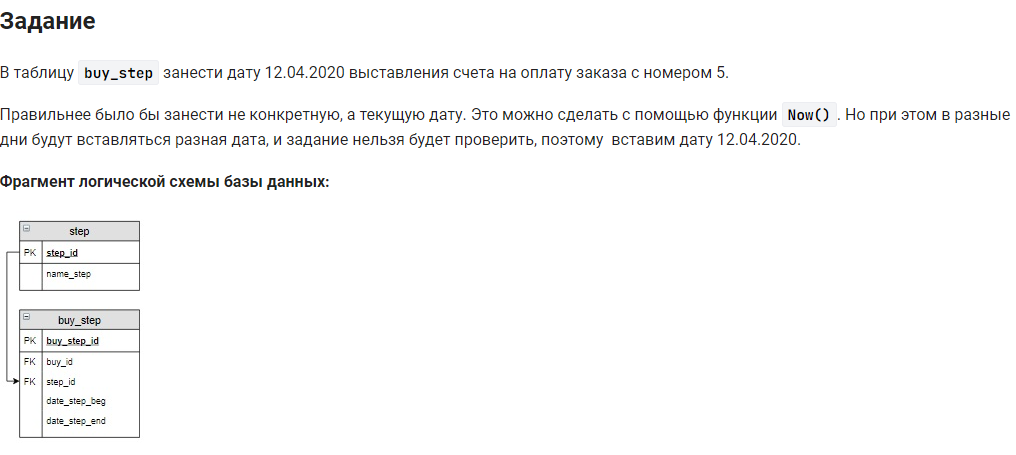

~~~~mySQL
UPDATE buy_step
 INNER JOIN step ON buy_step.buy_id = 5
                AND step.name_step = 'Оплата'
                AND step.step_id = buy_step.step_id
   SET date_step_beg = DATE('2020.04.12');
~~~~

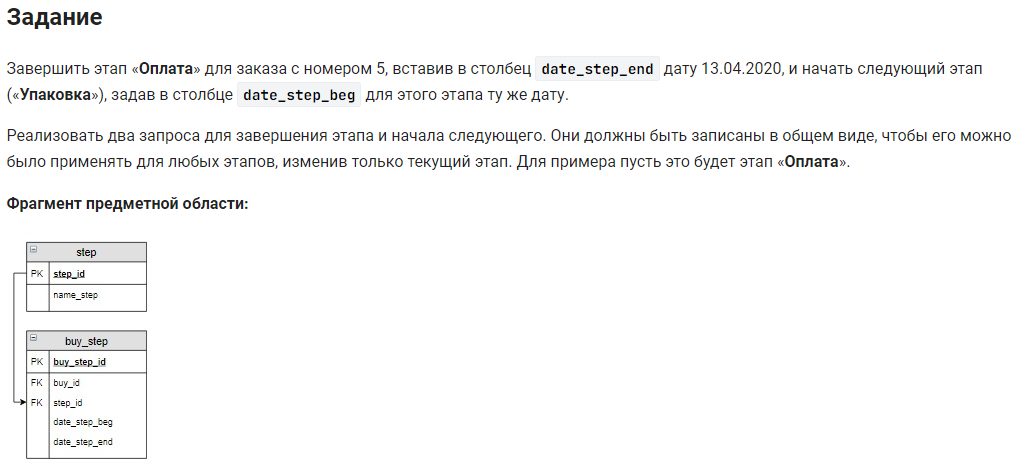

~~~~mySQL
UPDATE  buy_step
 INNER JOIN step ON step.name_step = 'Оплата'
                AND buy_step.buy_id = 5
                AND step.step_id = buy_step.step_id
   SET buy_step.date_step_end = DATE('2020.04.13');
   
UPDATE  buy_step
 INNER JOIN step ON step.name_step = 'Оплата'
                AND buy_step.buy_id = 5
                AND step.step_id + 1 = buy_step.step_id
   SET buy_step.date_step_beg = DATE('2020.04.13');
~~~~

~~~~mySQL
-- Без строчки ниже не работало 
SET collation_connection = 'utf8_general_ci';
SET @buy_id = 5;
SET @temp_date = DATE('2020.04.13');
SET @temp_step = 'Оплата';

UPDATE  buy_step
 INNER JOIN step ON step.name_step = @temp_step
                AND buy_step.buy_id = @buy_id
                AND step.step_id = buy_step.step_id
   SET buy_step.date_step_end = @temp_date;
   
UPDATE  buy_step
 INNER JOIN step ON step.name_step = @temp_step
                AND buy_step.buy_id = @buy_id
                AND step.step_id + 1 = buy_step.step_id
   SET buy_step.date_step_beg = @temp_date;

select * from buy_step
                                 
~~~~